In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import pickle
from copy import deepcopy

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from itertools import permutations, combinations

from datasets import Data_From_File
from sklearn.metrics import ndcg_score
from perms import Gk

import matplotlib.pyplot as plt

In [4]:
class Data_for_torch(Dataset, Data_From_File):
    
    def __init__(self, file, which = 0):
        
        self.data = pd.DataFrame(Data_From_File.open_file(file)[which]).drop('doc_id', axis = 1)
        self.dict_data = self.data.set_index('query_id').T.to_dict('list')
        self.keys = list(self.dict_data.keys())
        
    def __len__(self):
        return len(self.dict_data)
        
    def __getitem__(self, idx):
        key = self.keys[idx]
        return self.dict_data[key]

In [5]:
train_data = Data_for_torch('datas_full_10k_1.pkl', which = 0)
vali_data = Data_for_torch('datas_full_10k_1.pkl', which = -1)

In [6]:
train_loader = DataLoader(train_data, shuffle=True)
test_loader = DataLoader(vali_data, batch_size=1)

In [7]:
class ListNet(nn.Module):
    def __init__(self,inp_size = 136, out_size = 1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(inp_size, 256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,out_size),
            
            
        )
        
    def forward(self, X):
        return self.model(X)
    
    dict_y = {}

In [13]:
def get_ndcg():
    pass
def loss(p,y):
    return torch.sum(y * torch.log(y / (p + 1e-6)))

def train(train_dataloader, test_loader, model, loss_fn, optimizer,sheluder, epochs, device, test = False, test_dataloader = None, k = 1):
    global dict_y
    
    # model.to(device)
    def vali(loader = test_loader, device = 'cuda'):
        acc = 0
        
        length = len(loader)
        for batch in loader:
            # get_probs = torch.softma
            
            
            X = batch[0].to(device)
            y = batch[1].cpu().view(-1).numpy()
            
            preds = model(X.float()).view(-1).detach().cpu().numpy()
            # print(y.shape, preds.shape, X.shape)
            try:
                acc += ndcg_score([list(y)], [list(preds)])
            except:
                # acc += 1
                length -= 1
                continue
            
        return acc / length
    
    pred_probs = nn.Softmax(dim = -1)
    y_probs = nn.Softmax(dim = -1)
    
    train_loss = []
    metric = []
    
    model.train()
    for i in range(epochs):
        
        loss_epoch = 0
        
        
        for batch in train_dataloader:
            X = batch[0].float().to(device)
            y = batch[1].squeeze().float().to(device)
            
            preds = model(X).squeeze()
            
            probas_p = pred_probs(preds)
            probas_y = y_probs(y)
            
            loss_ = loss_fn(probas_p, probas_y)
            # los_ = kl_loss(probas_p, probas_y)
            # print(loss_)
            loss_.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_epoch += loss_
            
        sheluder.step(loss_epoch)  
        
        train_loss.append(loss_epoch.clone().detach().cpu().numpy()/6000)
        
        
        model.eval()
        metric.append(vali())
        print(loss_epoch/6000, 'metric = ', metric[i])
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         print(f'Градиент параметра {name}: {param.grad}')
        #     else:
        #         print(f'Градиент параметра {name} отсутствует')          
            
    return train_loss, metric
    
    
        
from sklearn.metrics import ndcg_score, dcg_score


    # return ndcg_score(list_of_y, list_of_preds)
        
def plot_loss(train_loss,label, y_label, num_epochs = 50):
        plt.figure(figsize = (10,10))
        
        fig, ax = plt.subplots()
        ax.set_title(label)
        ax.plot(range(num_epochs),train_loss)
        ax.set_xlabel('epochs')
        ax.set_ylabel(y_label)
        plt.grid()
        plt.show()
        
            

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ListNet().to(device)

kl_loss = nn.CrossEntropyLoss()

opt_adam = torch.optim.AdamW(model.parameters(), lr=0.0001)

m_loss = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_adam, mode='min', patience=3, factor=0.1, verbose=True)

/home/aletovv/anaconda3/envs/v-env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
model_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

Number of trainable parameters: 76289


'cuda'

In [11]:
losses = train(train_dataloader=train_loader,
               test_loader= test_loader,
      model = model,
      loss_fn=loss,
      optimizer=opt_adam,sheluder=scheduler,
      epochs=50,
      device = device)

tensor(8.9167, device='cuda:0', grad_fn=<DivBackward0>) metric =  0.6378181181607464
tensor(1.3861, device='cuda:0', grad_fn=<DivBackward0>) metric =  0.6674728441952762
tensor(0.7851, device='cuda:0', grad_fn=<DivBackward0>) metric =  0.6287587967984989
tensor(0.6468, device='cuda:0', grad_fn=<DivBackward0>) metric =  0.6898655423217359
tensor(0.6398, device='cuda:0', grad_fn=<DivBackward0>) metric =  0.6377253359229883
tensor(0.4725, device='cuda:0', grad_fn=<DivBackward0>) metric =  0.640499390752974
tensor(0.4440, device='cuda:0', grad_fn=<DivBackward0>) metric =  0.6400631017673214
tensor(0.4662, device='cuda:0', grad_fn=<DivBackward0>) metric =  0.6397853409217216
tensor(0.4400, device='cuda:0', grad_fn=<DivBackward0>) metric =  0.6390731617258878
tensor(0.4347, device='cuda:0', grad_fn=<DivBackward0>) metric =  0.6403418471370779
tensor(0.4412, device='cuda:0', grad_fn=<DivBackward0>) metric =  0.6391814935279425
tensor(0.4326, device='cuda:0', grad_fn=<DivBackward0>) metric =  

<Figure size 1000x1000 with 0 Axes>

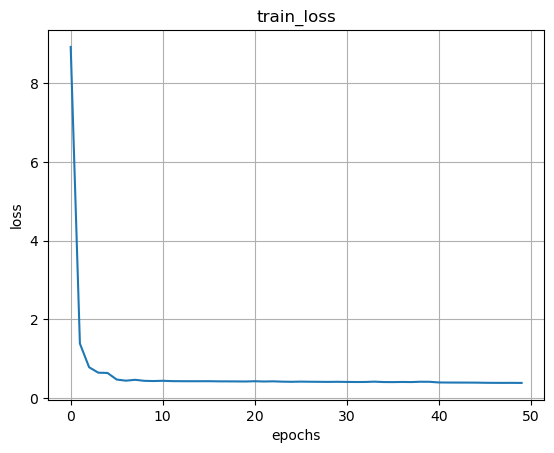

<Figure size 1000x1000 with 0 Axes>

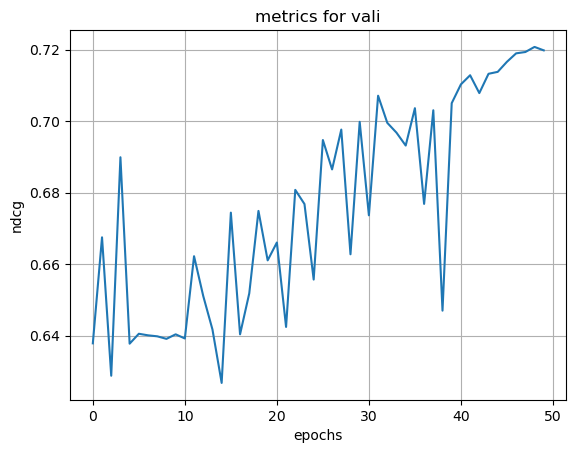

In [14]:
plot_loss(train_loss=losses[0], label='train_loss', y_label='loss')

plot_loss(train_loss = losses[1],label='metrics for vali', y_label='ndcg')

In [ ]:
# print(f'the ndcg_score for trained model = {vali(test_loader )}')

the ndcg_score for trained model = 0.6318917300367795
